In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate,cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, svm
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import seaborn
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.feature_selection import chi2, SelectKBest, SelectFdr
from sklearn.decomposition import PCA
from rake_nltk import Rake

Import data as data frame

In [2]:
# dataPath = "/mnt/c/Users/LJUDY/OneDrive/MyStuff/Work/FedEx/Shift Lead/Clustering Project/"
simplefile = "problem_pdsm_simple.csv"

data = pd.read_csv(simplefile)
data.head()

,Number,Priority,Business service,Category,Company,Created,Created by,Impact,Impacted OpCos,Major Problem,Parent,Problem Manager,Related Incidents,Type,Urgency
0,PRB0063212,5 - Planning,Server,Hardware,FedEx Services,2019-02-13 08:47:23,5163721,3 - Low,FedEx Services,True,INC011242667,Christopher Barber,1,ITCC,3 - Low
1,PRB0063211,5 - Planning,Database,Application,NaN,2019-02-13 08:49:50,3619116,3 - Low,FedEx Express APAC,False,NaN,Sathya Easwaran,0,Standard,3 - Low
2,PRB0063210,5 - Planning,Computer,Hardware,FedEx Services,2019-02-13 06:51:16,5163721,3 - Low,FedEx Ground,True,INC011241950,Divakar Durgapal,1,ITCC,3 - Low
3,PRB0063205,5 - Planning,Switch,Network,FedEx Services,2019-02-12 22:00:36,3667964,3 - Low,FedEx Ground,True,INC011240331,Christopher Barber,1,ITCC,3 - Low
4,PRB0063204,5 - Planning,Server,Hardware,FedEx Services,2019-02-12 21:03:05,836059,3 - Low,"FedEx Freight Inc., FedEx Office",True,INC011239460,Christopher Barber,1,ITCC,3 - Low


### Extract keywords from descriptions in full dataset
Adds Short Description and Keywords features to above dataset

In [3]:
def extract_keywords(text):
    r = Rake(min_length=2, max_length=8)
    r.extract_keywords_from_text(text)
    return r.get_ranked_phrases()[0:4]

In [4]:
full_data = pd.read_excel('problem_pdsm.xlsx')

desc_data = full_data[['Number', 'Short description']]
desc_data = desc_data[desc_data['Number'].isin(data['Number'])]
data = data.merge(desc_data, how='left', on='Number')
data['Keywords'] = data['Short description'].apply(extract_keywords)
data.head()

,Number,Priority,Business service,Category,Company,Created,Created by,Impact,Impacted OpCos,Major Problem,Parent,Problem Manager,Related Incidents,Type,Urgency,Short description,Keywords
0,PRB0063212,5 - Planning,Server,Hardware,FedEx Services,2019-02-13 08:47:23,5163721,3 - Low,FedEx Services,True,INC011242667,Christopher Barber,1,ITCC,3 - Low,CANCELLED - Lync issue that cleared with no kn...,"[short duration, lync issue, know intervention..."
1,PRB0063211,5 - Planning,Database,Application,NaN,2019-02-13 08:49:50,3619116,3 - Low,FedEx Express APAC,False,NaN,Sathya Easwaran,0,Standard,3 - Low,INC011235876-Sync issue between OMS and WMS fo...,"[inbound order status, sync issue]"
2,PRB0063210,5 - Planning,Computer,Hardware,FedEx Services,2019-02-13 06:51:16,5163721,3 - Low,FedEx Ground,True,INC011241950,Divakar Durgapal,1,ITCC,3 - Low,Ground locations are no longer reporting issue...,[longer reporting issues seeing vsa records wi...
3,PRB0063205,5 - Planning,Switch,Network,FedEx Services,2019-02-12 22:00:36,3667964,3 - Low,FedEx Ground,True,INC011240331,Christopher Barber,1,ITCC,3 - Low,CANCELLED - local power outage .,[local power outage]
4,PRB0063204,5 - Planning,Server,Hardware,FedEx Services,2019-02-12 21:03:05,836059,3 - Low,"FedEx Freight Inc., FedEx Office",True,INC011239460,Christopher Barber,1,ITCC,3 - Low,CANCELLED - issue cleared following a DB proce...,"[issue cleared following, db process completin..."


### Get number of incidents associated with each problem

In [5]:
incidents = pd.read_excel('incidents_with_problems.xlsx')
incidents.head()

,Number,Problem,Active,Activity due,Additional assignee list,Approval,Approval history,Approval set,Assigned to,Assignment group,...,Awareness (Min),CHECKOUT (MIN),ESCALATION (MIN),REMEDIATION (MIN),TIMELINE DURATION (MIN),TRIAGE (MIN),Acknowledge (Min),BSD call,New Call,Vendor Exception
0,INC010068680,PRB0060003,False,NaT,NaN,Not Yet Requested,NaN,NaN,NaN,FXS_SA_US_Voice,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,INC010000197,PRB0060003,False,NaT,NaN,Not Yet Requested,NaN,NaN,Kevin Moore,FXS_SA_US_Voice,...,66.0,0.0,0.0,14.0,362.0,282.0,66.0,NaN,NaN,NaN
2,INC010003952,PRB0060019,False,NaT,NaN,Not Yet Requested,NaN,NaN,Kevin Mathis,FXF_MobileHH,...,1.0,0.0,60.0,0.0,101.0,40.0,1.0,NaN,NaN,NaN
3,INC010269074,PRB0060026,False,NaT,NaN,Not Yet Requested,NaN,NaN,Rochelle Coleman,FXS_DBA_Dotcom,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,INC010269078,PRB0060026,False,NaT,NaN,Not Yet Requested,NaN,NaN,Rochelle Coleman,FXS_DBA_Dotcom,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
prob_counts = incidents['Problem'].value_counts().reset_index()
prob_counts = prob_counts.rename(columns={'index': 'Number', 'Problem': 'Incidents Count'})
prob_counts.head()

,Number,Incidents Count
0,PRB0060187,24
1,PRB0062159,15
2,PRB0060026,13
3,PRB0060146,10
4,PRB0060758,10


In [7]:
data = data.merge(prob_counts, how='left', on='Number')
data['Incidents Count'] = data['Incidents Count'].fillna(0).astype(int)
data.head()

,Number,Priority,Business service,Category,Company,Created,Created by,Impact,Impacted OpCos,Major Problem,Parent,Problem Manager,Related Incidents,Type,Urgency,Short description,Keywords,Incidents Count
0,PRB0063212,5 - Planning,Server,Hardware,FedEx Services,2019-02-13 08:47:23,5163721,3 - Low,FedEx Services,True,INC011242667,Christopher Barber,1,ITCC,3 - Low,CANCELLED - Lync issue that cleared with no kn...,"[short duration, lync issue, know intervention...",1
1,PRB0063211,5 - Planning,Database,Application,NaN,2019-02-13 08:49:50,3619116,3 - Low,FedEx Express APAC,False,NaN,Sathya Easwaran,0,Standard,3 - Low,INC011235876-Sync issue between OMS and WMS fo...,"[inbound order status, sync issue]",0
2,PRB0063210,5 - Planning,Computer,Hardware,FedEx Services,2019-02-13 06:51:16,5163721,3 - Low,FedEx Ground,True,INC011241950,Divakar Durgapal,1,ITCC,3 - Low,Ground locations are no longer reporting issue...,[longer reporting issues seeing vsa records wi...,1
3,PRB0063205,5 - Planning,Switch,Network,FedEx Services,2019-02-12 22:00:36,3667964,3 - Low,FedEx Ground,True,INC011240331,Christopher Barber,1,ITCC,3 - Low,CANCELLED - local power outage .,[local power outage],1
4,PRB0063204,5 - Planning,Server,Hardware,FedEx Services,2019-02-12 21:03:05,836059,3 - Low,"FedEx Freight Inc., FedEx Office",True,INC011239460,Christopher Barber,1,ITCC,3 - Low,CANCELLED - issue cleared following a DB proce...,"[issue cleared following, db process completin...",1


### Add assignment group from incidents to problems dataset

In [8]:
assign_groups = incidents[['Problem', 'Assignment group']]
assign_groups = assign_groups.rename(columns={'Problem':'Number'}).drop_duplicates('Number')
# assign_groups.head()
data = data.merge(assign_groups, how='left', on='Number')
data.head()

,Number,Priority,Business service,Category,Company,Created,Created by,Impact,Impacted OpCos,Major Problem,Parent,Problem Manager,Related Incidents,Type,Urgency,Short description,Keywords,Incidents Count,Assignment group
0,PRB0063212,5 - Planning,Server,Hardware,FedEx Services,2019-02-13 08:47:23,5163721,3 - Low,FedEx Services,True,INC011242667,Christopher Barber,1,ITCC,3 - Low,CANCELLED - Lync issue that cleared with no kn...,"[short duration, lync issue, know intervention...",1,FXS_SPT_GLB_Skype
1,PRB0063211,5 - Planning,Database,Application,NaN,2019-02-13 08:49:50,3619116,3 - Low,FedEx Express APAC,False,NaN,Sathya Easwaran,0,Standard,3 - Low,INC011235876-Sync issue between OMS and WMS fo...,"[inbound order status, sync issue]",0,NaN
2,PRB0063210,5 - Planning,Computer,Hardware,FedEx Services,2019-02-13 06:51:16,5163721,3 - Low,FedEx Ground,True,INC011241950,Divakar Durgapal,1,ITCC,3 - Low,Ground locations are no longer reporting issue...,[longer reporting issues seeing vsa records wi...,1,FXG_PKGROUTINGSYS
3,PRB0063205,5 - Planning,Switch,Network,FedEx Services,2019-02-12 22:00:36,3667964,3 - Low,FedEx Ground,True,INC011240331,Christopher Barber,1,ITCC,3 - Low,CANCELLED - local power outage .,[local power outage],1,FXS_SPT_GLB_NOCL1
4,PRB0063204,5 - Planning,Server,Hardware,FedEx Services,2019-02-12 21:03:05,836059,3 - Low,"FedEx Freight Inc., FedEx Office",True,INC011239460,Christopher Barber,1,ITCC,3 - Low,CANCELLED - issue cleared following a DB proce...,"[issue cleared following, db process completin...",1,FXS_SPT_US_InfraTools


### Get avg, min, and max duration of related incidents for each problem

In [9]:
durations = incidents[['Problem','Duration']]
durations = durations.rename(columns={'Problem':'Number'})
# durations.groupby(['Number']).mean()
durations['Duration Max'] = durations.Number.map(durations.groupby(['Number'])['Duration'].max())
durations['Duration Mean'] = durations.Number.map(durations.groupby(['Number'])['Duration'].mean())
durations['Duration Min'] = durations.Number.map(durations.groupby(['Number'])['Duration'].min())
durations['Duration Range'] = durations['Duration Max'] - durations['Duration Min']
durations = durations.drop_duplicates('Number').drop('Duration', axis=1)
durations.head()

,Number,Duration Max,Duration Mean,Duration Min,Duration Range
0,PRB0060003,4009074,2.474298e+06,939522,3069552
2,PRB0060019,9075,9.075000e+03,9075,0
3,PRB0060026,3885207,3.885204e+06,3885201,6
16,PRB0060029,87041,8.704100e+04,87041,0
17,PRB0060030,22042,2.204200e+04,22042,0


In [10]:
data = data.merge(durations, how='left', on='Number')
data.head()

,Number,Priority,Business service,Category,Company,Created,Created by,Impact,Impacted OpCos,Major Problem,...,Type,Urgency,Short description,Keywords,Incidents Count,Assignment group,Duration Max,Duration Mean,Duration Min,Duration Range
0,PRB0063212,5 - Planning,Server,Hardware,FedEx Services,2019-02-13 08:47:23,5163721,3 - Low,FedEx Services,True,...,ITCC,3 - Low,CANCELLED - Lync issue that cleared with no kn...,"[short duration, lync issue, know intervention...",1,FXS_SPT_GLB_Skype,3346.0,3346.0,3346.0,0.0
1,PRB0063211,5 - Planning,Database,Application,NaN,2019-02-13 08:49:50,3619116,3 - Low,FedEx Express APAC,False,...,Standard,3 - Low,INC011235876-Sync issue between OMS and WMS fo...,"[inbound order status, sync issue]",0,NaN,NaN,NaN,NaN,NaN
2,PRB0063210,5 - Planning,Computer,Hardware,FedEx Services,2019-02-13 06:51:16,5163721,3 - Low,FedEx Ground,True,...,ITCC,3 - Low,Ground locations are no longer reporting issue...,[longer reporting issues seeing vsa records wi...,1,FXG_PKGROUTINGSYS,7250.0,7250.0,7250.0,0.0
3,PRB0063205,5 - Planning,Switch,Network,FedEx Services,2019-02-12 22:00:36,3667964,3 - Low,FedEx Ground,True,...,ITCC,3 - Low,CANCELLED - local power outage .,[local power outage],1,FXS_SPT_GLB_NOCL1,6856.0,6856.0,6856.0,0.0
4,PRB0063204,5 - Planning,Server,Hardware,FedEx Services,2019-02-12 21:03:05,836059,3 - Low,"FedEx Freight Inc., FedEx Office",True,...,ITCC,3 - Low,CANCELLED - issue cleared following a DB proce...,"[issue cleared following, db process completin...",1,FXS_SPT_US_InfraTools,11000.0,11000.0,11000.0,0.0


### Find similar keywords within related incidents

## Clean the data

Find out default types for the columns

In [11]:
data.dtypes

Number                object
Priority              object
Business service      object
Category              object
Company               object
Created               object
Created by            object
Impact                object
Impacted OpCos        object
Major Problem           bool
Parent                object
Problem Manager       object
Related Incidents      int64
Type                  object
Urgency               object
Short description     object
Keywords              object
Incidents Count        int64
Assignment group      object
Duration Max         float64
Duration Mean        float64
Duration Min         float64
Duration Range       float64
dtype: object

### Number column

Remove the PRB prefix from the Number column and convert it to a number

In [12]:
data['Number'] = data['Number'].map(lambda x: x.lstrip('PRB'))
data['Number'] = pd.to_numeric(data['Number'])
data.head()

,Number,Priority,Business service,Category,Company,Created,Created by,Impact,Impacted OpCos,Major Problem,...,Type,Urgency,Short description,Keywords,Incidents Count,Assignment group,Duration Max,Duration Mean,Duration Min,Duration Range
0,63212,5 - Planning,Server,Hardware,FedEx Services,2019-02-13 08:47:23,5163721,3 - Low,FedEx Services,True,...,ITCC,3 - Low,CANCELLED - Lync issue that cleared with no kn...,"[short duration, lync issue, know intervention...",1,FXS_SPT_GLB_Skype,3346.0,3346.0,3346.0,0.0
1,63211,5 - Planning,Database,Application,NaN,2019-02-13 08:49:50,3619116,3 - Low,FedEx Express APAC,False,...,Standard,3 - Low,INC011235876-Sync issue between OMS and WMS fo...,"[inbound order status, sync issue]",0,NaN,NaN,NaN,NaN,NaN
2,63210,5 - Planning,Computer,Hardware,FedEx Services,2019-02-13 06:51:16,5163721,3 - Low,FedEx Ground,True,...,ITCC,3 - Low,Ground locations are no longer reporting issue...,[longer reporting issues seeing vsa records wi...,1,FXG_PKGROUTINGSYS,7250.0,7250.0,7250.0,0.0
3,63205,5 - Planning,Switch,Network,FedEx Services,2019-02-12 22:00:36,3667964,3 - Low,FedEx Ground,True,...,ITCC,3 - Low,CANCELLED - local power outage .,[local power outage],1,FXS_SPT_GLB_NOCL1,6856.0,6856.0,6856.0,0.0
4,63204,5 - Planning,Server,Hardware,FedEx Services,2019-02-12 21:03:05,836059,3 - Low,"FedEx Freight Inc., FedEx Office",True,...,ITCC,3 - Low,CANCELLED - issue cleared following a DB proce...,"[issue cleared following, db process completin...",1,FXS_SPT_US_InfraTools,11000.0,11000.0,11000.0,0.0


In [13]:
data.dtypes

Number                 int64
Priority              object
Business service      object
Category              object
Company               object
Created               object
Created by            object
Impact                object
Impacted OpCos        object
Major Problem           bool
Parent                object
Problem Manager       object
Related Incidents      int64
Type                  object
Urgency               object
Short description     object
Keywords              object
Incidents Count        int64
Assignment group      object
Duration Max         float64
Duration Mean        float64
Duration Min         float64
Duration Range       float64
dtype: object

### Priority, Impact, and Urgency

Take the first character (number) from each and convert to numeric

In [14]:
data['Priority'] = data['Priority'].map(lambda x: x[0])
data['Priority'] = pd.to_numeric(data['Priority'])

data['Impact'] = data['Impact'].map(lambda x: x[0])
data['Impact'] = pd.to_numeric(data['Impact'])

data['Urgency'] = data['Urgency'].map(lambda x: x[0])
data['Urgency'] = pd.to_numeric(data['Urgency'])

data.head()

,Number,Priority,Business service,Category,Company,Created,Created by,Impact,Impacted OpCos,Major Problem,...,Type,Urgency,Short description,Keywords,Incidents Count,Assignment group,Duration Max,Duration Mean,Duration Min,Duration Range
0,63212,5,Server,Hardware,FedEx Services,2019-02-13 08:47:23,5163721,3,FedEx Services,True,...,ITCC,3,CANCELLED - Lync issue that cleared with no kn...,"[short duration, lync issue, know intervention...",1,FXS_SPT_GLB_Skype,3346.0,3346.0,3346.0,0.0
1,63211,5,Database,Application,NaN,2019-02-13 08:49:50,3619116,3,FedEx Express APAC,False,...,Standard,3,INC011235876-Sync issue between OMS and WMS fo...,"[inbound order status, sync issue]",0,NaN,NaN,NaN,NaN,NaN
2,63210,5,Computer,Hardware,FedEx Services,2019-02-13 06:51:16,5163721,3,FedEx Ground,True,...,ITCC,3,Ground locations are no longer reporting issue...,[longer reporting issues seeing vsa records wi...,1,FXG_PKGROUTINGSYS,7250.0,7250.0,7250.0,0.0
3,63205,5,Switch,Network,FedEx Services,2019-02-12 22:00:36,3667964,3,FedEx Ground,True,...,ITCC,3,CANCELLED - local power outage .,[local power outage],1,FXS_SPT_GLB_NOCL1,6856.0,6856.0,6856.0,0.0
4,63204,5,Server,Hardware,FedEx Services,2019-02-12 21:03:05,836059,3,"FedEx Freight Inc., FedEx Office",True,...,ITCC,3,CANCELLED - issue cleared following a DB proce...,"[issue cleared following, db process completin...",1,FXS_SPT_US_InfraTools,11000.0,11000.0,11000.0,0.0


In [15]:
data.dtypes

Number                 int64
Priority               int64
Business service      object
Category              object
Company               object
Created               object
Created by            object
Impact                 int64
Impacted OpCos        object
Major Problem           bool
Parent                object
Problem Manager       object
Related Incidents      int64
Type                  object
Urgency                int64
Short description     object
Keywords              object
Incidents Count        int64
Assignment group      object
Duration Max         float64
Duration Mean        float64
Duration Min         float64
Duration Range       float64
dtype: object

### Categorical Fields

Check out category counts

In [16]:
data['Business service'].value_counts()

Server                          592
Computer                        484
Network                         127
Database                        122
Communication Device             71
Scanner                          45
Mainframe                        29
Printer                          21
Switch                           13
Storage                          12
Enterprise-Data-Analytics         9
Router                            7
Firewall                          6
Circuit                           3
Peripheral                        2
CSVS-1SRC-Rating                  2
SASV                              2
EIS-ITO-CS-Operating-Systems      2
Sorter                            2
Physical                          2
AOSD-FPS                          1
AOSD-FOCUS                        1
CRDT                              1
FXO-CI                            1
FXF-IMAGING                       1
GRD-Scanner-Forms-System          1
NCOI-GRID                         1
Avaya                       

In [17]:
data['Category'].value_counts()

Application       1077
Hardware           267
Network             41
Inquiry / Help      39
Infrastructure      32
Security            13
Telephony            5
Environment          2
Name: Category, dtype: int64

In [18]:
data['Company'].value_counts()

FedEx Services               565
FedEx Express                 97
FedEx Ground                  85
FedEx Freight Inc.            28
TNT Express-422               19
FedEx Office                   8
FedEx Supply Chain             2
FedEx Ground LTD               2
TNT                            1
FedEx Supply Chain, Inc.       1
FTN Transport & Brokerage      1
FedEx                          1
Name: Company, dtype: int64

In [19]:
data['Problem Manager'].value_counts()

Christopher Barber     145
Eli Smith              117
Naveen Kumar           114
Daniel Smith           110
Matthew Gonderinger     98
Christophe Gurley       88
Brad Moore              81
Mark Duncan             78
Michael Kennemer        67
Christina Hanlin        67
Dawn Gallo              63
Terri Hamilton          61
Greg Malek              60
Randall Painter         59
Stephen Wolff           40
Michael Olton           39
Charles McClain         34
Sami Al-Chokhachi       21
Sathya Easwaran         20
Carl Hartman            19
Roberto Lopez           18
D'Zundra Green          12
Dana Dennis             11
Stephen Barch           10
LaToya Williams         10
Gregory Burkhead         9
Joseph LaRosa            8
Rajesh Ramanujachar      8
Kiran Kumar              8
Richard Harwood          7
                      ... 
Jeffrey Spinks           1
Vincent Gatti            1
Se Park                  1
Mark Martin              1
Michael Grondahl         1
Cheryl Derrig            1
R

In [20]:
data['Type'].value_counts()

ITCC         848
Standard     683
Proactive     81
Name: Type, dtype: int64

In [21]:
data['Assignment group'].value_counts()

FXS_L2ITCC                      37
FXS_SPT_GLB_NOCL1               27
FXS_EIS_GLB_ProblemMgmt         21
FXS_WASDRATINGTRACKING          20
FXS_SA_GLB_ADS                  16
FSC_SPT_GLB_Level2              14
FXG_SPT_FASS_SingleSystem       14
FXS_SPT_GLB_NOCL2               14
FXF_SPT_US_FreightDataSvcs      13
FXS_SPT_GLB_SharePoint          13
FXS_NET_ENT_DATACENTER_ENG      12
FXS_SA_Server                   11
FSC_ITL3O2STIBCO                10
FXS_SA_US_ITOWindowsServer       9
FXS_SPT_GLB_Skype                8
FXS_NETWORK_ENTERPRISE_ENG       8
FXS_SupportCCII                  7
FXS_DBA_US_HCL                   7
FXS_SPT_US_DOTCOMSHIPPING        7
FXF_SPT_Web_and_API_Services     7
FXS_SPT_IMS                      6
FXS_RIHITIH                      6
FXG_SPT_FASS_ISS                 6
FXG_SPT_FASS_International       6
FXG_SPT_US_TMSL3                 6
FXS_SA_US_Voice                  6
FSC_SPT_APAC_L2                  6
FXG_SPT_US_VisionPreload         6
FXS_AOSD_US_Weightan

Cut categories with low counts and add together to make an "Other" category

In [22]:
data = data.apply(lambda x: x.mask(x.map(x.value_counts())<10, 'Other') if x.name=='Business service' else x)
data = data.apply(lambda x: x.mask(x.map(x.value_counts())<10, 'Other') if x.name=='Company' else x)
data = data.apply(lambda x: x.mask(x.map(x.value_counts())<10, 'Other') if x.name=='Problem Manager' else x)
data = data.apply(lambda x: x.mask(x.map(x.value_counts())<10, 'Other') if x.name=='Type' else x)
data = data.apply(lambda x: x.mask(x.map(x.value_counts())<10, 'Other') if x.name=='Assignment group' else x)
data.head()

,Number,Priority,Business service,Category,Company,Created,Created by,Impact,Impacted OpCos,Major Problem,...,Type,Urgency,Short description,Keywords,Incidents Count,Assignment group,Duration Max,Duration Mean,Duration Min,Duration Range
0,63212,5,Server,Hardware,FedEx Services,2019-02-13 08:47:23,5163721,3,FedEx Services,True,...,ITCC,3,CANCELLED - Lync issue that cleared with no kn...,"[short duration, lync issue, know intervention...",1,Other,3346.0,3346.0,3346.0,0.0
1,63211,5,Database,Application,NaN,2019-02-13 08:49:50,3619116,3,FedEx Express APAC,False,...,Standard,3,INC011235876-Sync issue between OMS and WMS fo...,"[inbound order status, sync issue]",0,NaN,NaN,NaN,NaN,NaN
2,63210,5,Computer,Hardware,FedEx Services,2019-02-13 06:51:16,5163721,3,FedEx Ground,True,...,ITCC,3,Ground locations are no longer reporting issue...,[longer reporting issues seeing vsa records wi...,1,Other,7250.0,7250.0,7250.0,0.0
3,63205,5,Switch,Network,FedEx Services,2019-02-12 22:00:36,3667964,3,FedEx Ground,True,...,ITCC,3,CANCELLED - local power outage .,[local power outage],1,FXS_SPT_GLB_NOCL1,6856.0,6856.0,6856.0,0.0
4,63204,5,Server,Hardware,FedEx Services,2019-02-12 21:03:05,836059,3,"FedEx Freight Inc., FedEx Office",True,...,ITCC,3,CANCELLED - issue cleared following a DB proce...,"[issue cleared following, db process completin...",1,Other,11000.0,11000.0,11000.0,0.0


Convert categorical fields to be a category type

In [23]:
data['Business service'] = data['Business service'].astype('category')
data['Category'] = data['Category'].astype('category')
data['Company'] = data['Company'].astype('category')
data['Problem Manager'] = data['Problem Manager'].astype('category')
data['Type'] = data['Type'].astype('category')
data['Assignment group'] = data['Assignment group'].astype('category')
data.head()

,Number,Priority,Business service,Category,Company,Created,Created by,Impact,Impacted OpCos,Major Problem,...,Type,Urgency,Short description,Keywords,Incidents Count,Assignment group,Duration Max,Duration Mean,Duration Min,Duration Range
0,63212,5,Server,Hardware,FedEx Services,2019-02-13 08:47:23,5163721,3,FedEx Services,True,...,ITCC,3,CANCELLED - Lync issue that cleared with no kn...,"[short duration, lync issue, know intervention...",1,Other,3346.0,3346.0,3346.0,0.0
1,63211,5,Database,Application,NaN,2019-02-13 08:49:50,3619116,3,FedEx Express APAC,False,...,Standard,3,INC011235876-Sync issue between OMS and WMS fo...,"[inbound order status, sync issue]",0,NaN,NaN,NaN,NaN,NaN
2,63210,5,Computer,Hardware,FedEx Services,2019-02-13 06:51:16,5163721,3,FedEx Ground,True,...,ITCC,3,Ground locations are no longer reporting issue...,[longer reporting issues seeing vsa records wi...,1,Other,7250.0,7250.0,7250.0,0.0
3,63205,5,Switch,Network,FedEx Services,2019-02-12 22:00:36,3667964,3,FedEx Ground,True,...,ITCC,3,CANCELLED - local power outage .,[local power outage],1,FXS_SPT_GLB_NOCL1,6856.0,6856.0,6856.0,0.0
4,63204,5,Server,Hardware,FedEx Services,2019-02-12 21:03:05,836059,3,"FedEx Freight Inc., FedEx Office",True,...,ITCC,3,CANCELLED - issue cleared following a DB proce...,"[issue cleared following, db process completin...",1,Other,11000.0,11000.0,11000.0,0.0


In [24]:
data.dtypes

Number                  int64
Priority                int64
Business service     category
Category             category
Company              category
Created                object
Created by             object
Impact                  int64
Impacted OpCos         object
Major Problem            bool
Parent                 object
Problem Manager      category
Related Incidents       int64
Type                 category
Urgency                 int64
Short description      object
Keywords               object
Incidents Count         int64
Assignment group     category
Duration Max          float64
Duration Mean         float64
Duration Min          float64
Duration Range        float64
dtype: object

### Created

Convert the Created column to a datetime type

In [25]:
data['Created'] = data['Created'].astype('datetime64[ns]')
data.head()

,Number,Priority,Business service,Category,Company,Created,Created by,Impact,Impacted OpCos,Major Problem,...,Type,Urgency,Short description,Keywords,Incidents Count,Assignment group,Duration Max,Duration Mean,Duration Min,Duration Range
0,63212,5,Server,Hardware,FedEx Services,2019-02-13 08:47:23,5163721,3,FedEx Services,True,...,ITCC,3,CANCELLED - Lync issue that cleared with no kn...,"[short duration, lync issue, know intervention...",1,Other,3346.0,3346.0,3346.0,0.0
1,63211,5,Database,Application,NaN,2019-02-13 08:49:50,3619116,3,FedEx Express APAC,False,...,Standard,3,INC011235876-Sync issue between OMS and WMS fo...,"[inbound order status, sync issue]",0,NaN,NaN,NaN,NaN,NaN
2,63210,5,Computer,Hardware,FedEx Services,2019-02-13 06:51:16,5163721,3,FedEx Ground,True,...,ITCC,3,Ground locations are no longer reporting issue...,[longer reporting issues seeing vsa records wi...,1,Other,7250.0,7250.0,7250.0,0.0
3,63205,5,Switch,Network,FedEx Services,2019-02-12 22:00:36,3667964,3,FedEx Ground,True,...,ITCC,3,CANCELLED - local power outage .,[local power outage],1,FXS_SPT_GLB_NOCL1,6856.0,6856.0,6856.0,0.0
4,63204,5,Server,Hardware,FedEx Services,2019-02-12 21:03:05,836059,3,"FedEx Freight Inc., FedEx Office",True,...,ITCC,3,CANCELLED - issue cleared following a DB proce...,"[issue cleared following, db process completin...",1,Other,11000.0,11000.0,11000.0,0.0


In [26]:
data.dtypes

Number                        int64
Priority                      int64
Business service           category
Category                   category
Company                    category
Created              datetime64[ns]
Created by                   object
Impact                        int64
Impacted OpCos               object
Major Problem                  bool
Parent                       object
Problem Manager            category
Related Incidents             int64
Type                       category
Urgency                       int64
Short description            object
Keywords                     object
Incidents Count               int64
Assignment group           category
Duration Max                float64
Duration Mean               float64
Duration Min                float64
Duration Range              float64
dtype: object

### Created by

Convert the Created by column to a number

In [27]:
data['Created by'] = pd.to_numeric(data['Created by'])
data.head()

ValueError: Unable to parse string "admin5069733" at position 905

Looks like there may be some that have "admin" before the id number. I am just going to remove this prefix.

In [28]:
data['Created by'] = data['Created by'].map(lambda x: x.lstrip('admin'))
data['Created by'] = pd.to_numeric(data['Created by'])
data.head()

,Number,Priority,Business service,Category,Company,Created,Created by,Impact,Impacted OpCos,Major Problem,...,Type,Urgency,Short description,Keywords,Incidents Count,Assignment group,Duration Max,Duration Mean,Duration Min,Duration Range
0,63212,5,Server,Hardware,FedEx Services,2019-02-13 08:47:23,5163721,3,FedEx Services,True,...,ITCC,3,CANCELLED - Lync issue that cleared with no kn...,"[short duration, lync issue, know intervention...",1,Other,3346.0,3346.0,3346.0,0.0
1,63211,5,Database,Application,NaN,2019-02-13 08:49:50,3619116,3,FedEx Express APAC,False,...,Standard,3,INC011235876-Sync issue between OMS and WMS fo...,"[inbound order status, sync issue]",0,NaN,NaN,NaN,NaN,NaN
2,63210,5,Computer,Hardware,FedEx Services,2019-02-13 06:51:16,5163721,3,FedEx Ground,True,...,ITCC,3,Ground locations are no longer reporting issue...,[longer reporting issues seeing vsa records wi...,1,Other,7250.0,7250.0,7250.0,0.0
3,63205,5,Switch,Network,FedEx Services,2019-02-12 22:00:36,3667964,3,FedEx Ground,True,...,ITCC,3,CANCELLED - local power outage .,[local power outage],1,FXS_SPT_GLB_NOCL1,6856.0,6856.0,6856.0,0.0
4,63204,5,Server,Hardware,FedEx Services,2019-02-12 21:03:05,836059,3,"FedEx Freight Inc., FedEx Office",True,...,ITCC,3,CANCELLED - issue cleared following a DB proce...,"[issue cleared following, db process completin...",1,Other,11000.0,11000.0,11000.0,0.0


In [29]:
data.dtypes

Number                        int64
Priority                      int64
Business service           category
Category                   category
Company                    category
Created              datetime64[ns]
Created by                    int64
Impact                        int64
Impacted OpCos               object
Major Problem                  bool
Parent                       object
Problem Manager            category
Related Incidents             int64
Type                       category
Urgency                       int64
Short description            object
Keywords                     object
Incidents Count               int64
Assignment group           category
Duration Max                float64
Duration Mean               float64
Duration Min                float64
Duration Range              float64
dtype: object

### Impacted OpCos

Split Impacted OpCos column into list of OpCos instead of string

In [30]:
data['Impacted OpCos'] = data['Impacted OpCos'].map(lambda x: x.split(","))

AttributeError: 'float' object has no attribute 'split'

Weird.. Let's look for that float 

In [31]:
data[data['Impacted OpCos'].apply(np.isreal)]

,Number,Priority,Business service,Category,Company,Created,Created by,Impact,Impacted OpCos,Major Problem,...,Type,Urgency,Short description,Keywords,Incidents Count,Assignment group,Duration Max,Duration Mean,Duration Min,Duration Range
94,62775,5,Communication Device,Hardware,FedEx Express,2019-01-26 07:22:01,5163721,3,NaN,False,...,NaN,3,cancelled was only one userPPAD data not downl...,"[one userppad data, location like pnqvg, syste...",0,NaN,NaN,NaN,NaN,NaN
244,62336,5,Computer,Hardware,Other,2018-12-20 11:31:14,5163721,3,NaN,True,...,NaN,3,FXO-OPW: Black screen on all machines after ED...,"[edsm updates, black screen]",1,Other,23927.0,23927.0,23927.0,0.0
405,61944,5,Communication Device,Application,FedEx Express,2018-11-16 07:18:18,882238,3,NaN,False,...,NaN,3,VMWARE not working on Phone. Samsung A7 model....,"[setup outlook inbox, samsung a7 model]",1,Other,1832079.0,1832079.0,1832079.0,0.0
494,61676,5,Database,Application,FedEx Services,2018-10-26 08:59:48,192015,3,NaN,True,...,NaN,3,EMEA helpdesk reported some users from the ME...,[facing issues receiving email || issueonly im...,1,Other,107226.0,107226.0,107226.0,0.0
524,61582,5,Communication Device,Application,FedEx Ground,2018-10-18 19:09:36,2668981,3,NaN,False,...,NaN,3,3530712 (TRAILER MONITORING UNIT) Minor TMU TM...,"[trailer monitoring unit, minor tmu tmumonitor]",1,Other,40523.0,40523.0,40523.0,0.0
525,61581,5,Computer,Hardware,FedEx Services,2018-10-18 18:53:03,973921,3,NaN,True,...,NaN,3,Pittsburg facilities received a pre action low...,"[pre action low air pressure alarm, fire suppr...",1,FXS_L2ITCC,797352.0,797352.0,797352.0,0.0
583,61471,5,Scanner,Hardware,Other,2018-10-02 17:10:48,752021,3,NaN,False,...,NaN,3,FXO : SIM scanner is not working.,[sim scanner],1,Other,4265.0,4265.0,4265.0,0.0
601,61447,5,Network,Hardware,FedEx Services,2018-09-27 11:34:28,5163721,3,NaN,True,...,NaN,3,Users at ground location 0104/BRONX are report...,"[utilizing offline inbound scan, reporting net...",1,FXS_SPT_GLB_NOCL1,8602.0,8602.0,8602.0,0.0
631,61405,5,Server,Hardware,FedEx Services,2018-09-20 15:06:30,5285658,3,NaN,False,...,NaN,3,Intermittent rate quote failures (proactive re...,"[intermittent rate quote failures, proactive r...",1,FXS_L2ITCC,4132609.0,4132609.0,4132609.0,0.0
859,61051,5,Other,NaN,NaN,2018-07-20 17:01:21,644707,3,NaN,False,...,NaN,3,Opened in error (Please see PRB0060280),[please see prb0060280],0,NaN,NaN,NaN,NaN,NaN


Looks like the NaNs are the problem. Convert NaNs to empty strings.

In [32]:
data['Impacted OpCos'] = data['Impacted OpCos'].replace(np.nan, '', regex=True)
data[data['Impacted OpCos'].apply(np.isreal)]

,Number,Priority,Business service,Category,Company,Created,Created by,Impact,Impacted OpCos,Major Problem,...,Type,Urgency,Short description,Keywords,Incidents Count,Assignment group,Duration Max,Duration Mean,Duration Min,Duration Range


There's no longer any NaNs, so let's try the split again

In [33]:
data['Impacted OpCos'] = data['Impacted OpCos'].map(lambda x: x.split(","))
data.head()

,Number,Priority,Business service,Category,Company,Created,Created by,Impact,Impacted OpCos,Major Problem,...,Type,Urgency,Short description,Keywords,Incidents Count,Assignment group,Duration Max,Duration Mean,Duration Min,Duration Range
0,63212,5,Server,Hardware,FedEx Services,2019-02-13 08:47:23,5163721,3,[FedEx Services],True,...,ITCC,3,CANCELLED - Lync issue that cleared with no kn...,"[short duration, lync issue, know intervention...",1,Other,3346.0,3346.0,3346.0,0.0
1,63211,5,Database,Application,NaN,2019-02-13 08:49:50,3619116,3,[FedEx Express APAC],False,...,Standard,3,INC011235876-Sync issue between OMS and WMS fo...,"[inbound order status, sync issue]",0,NaN,NaN,NaN,NaN,NaN
2,63210,5,Computer,Hardware,FedEx Services,2019-02-13 06:51:16,5163721,3,[FedEx Ground],True,...,ITCC,3,Ground locations are no longer reporting issue...,[longer reporting issues seeing vsa records wi...,1,Other,7250.0,7250.0,7250.0,0.0
3,63205,5,Switch,Network,FedEx Services,2019-02-12 22:00:36,3667964,3,[FedEx Ground],True,...,ITCC,3,CANCELLED - local power outage .,[local power outage],1,FXS_SPT_GLB_NOCL1,6856.0,6856.0,6856.0,0.0
4,63204,5,Server,Hardware,FedEx Services,2019-02-12 21:03:05,836059,3,"[FedEx Freight Inc., FedEx Office]",True,...,ITCC,3,CANCELLED - issue cleared following a DB proce...,"[issue cleared following, db process completin...",1,Other,11000.0,11000.0,11000.0,0.0


Now we have the list, but we can't do anything with the list. Let's convert to dummy variables.

In [34]:
pd.get_dummies(data['Impacted OpCos'].apply(pd.Series).stack()).sum(level=0).head()

,,FedEx,FedEx Custom Critical,FedEx Express,FedEx Express APAC,FedEx Express Canada,FedEx Express Domestic,FedEx Express LAC,FedEx Express MEISA,FedEx Freight Corporate,...,FedEx SmartPost,FedEx Supply Chain,FedEx Trade Networks,Federal Express (Aruba) N.V.,TNT APAC,TNT Australia,TNT Corporate,TNT Express Global Networks,TNT Express-422,TNT Slovenia
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


That will take a lot of further processing, so I am going to drop that for now.

In [35]:
data = data.drop('Impacted OpCos', axis=1)
data.head()

,Number,Priority,Business service,Category,Company,Created,Created by,Impact,Major Problem,Parent,...,Type,Urgency,Short description,Keywords,Incidents Count,Assignment group,Duration Max,Duration Mean,Duration Min,Duration Range
0,63212,5,Server,Hardware,FedEx Services,2019-02-13 08:47:23,5163721,3,True,INC011242667,...,ITCC,3,CANCELLED - Lync issue that cleared with no kn...,"[short duration, lync issue, know intervention...",1,Other,3346.0,3346.0,3346.0,0.0
1,63211,5,Database,Application,NaN,2019-02-13 08:49:50,3619116,3,False,NaN,...,Standard,3,INC011235876-Sync issue between OMS and WMS fo...,"[inbound order status, sync issue]",0,NaN,NaN,NaN,NaN,NaN
2,63210,5,Computer,Hardware,FedEx Services,2019-02-13 06:51:16,5163721,3,True,INC011241950,...,ITCC,3,Ground locations are no longer reporting issue...,[longer reporting issues seeing vsa records wi...,1,Other,7250.0,7250.0,7250.0,0.0
3,63205,5,Switch,Network,FedEx Services,2019-02-12 22:00:36,3667964,3,True,INC011240331,...,ITCC,3,CANCELLED - local power outage .,[local power outage],1,FXS_SPT_GLB_NOCL1,6856.0,6856.0,6856.0,0.0
4,63204,5,Server,Hardware,FedEx Services,2019-02-12 21:03:05,836059,3,True,INC011239460,...,ITCC,3,CANCELLED - issue cleared following a DB proce...,"[issue cleared following, db process completin...",1,Other,11000.0,11000.0,11000.0,0.0


In [36]:
data.dtypes

Number                        int64
Priority                      int64
Business service           category
Category                   category
Company                    category
Created              datetime64[ns]
Created by                    int64
Impact                        int64
Major Problem                  bool
Parent                       object
Problem Manager            category
Related Incidents             int64
Type                       category
Urgency                       int64
Short description            object
Keywords                     object
Incidents Count               int64
Assignment group           category
Duration Max                float64
Duration Mean               float64
Duration Min                float64
Duration Range              float64
dtype: object

### Parent

Convert Parent column to a boolean Has Parent column

In [37]:
data['Has Parent'] = data['Parent'].map(lambda x: not(np.isreal(x)))
data = data.drop('Parent', axis=1)
data.head()

,Number,Priority,Business service,Category,Company,Created,Created by,Impact,Major Problem,Problem Manager,...,Urgency,Short description,Keywords,Incidents Count,Assignment group,Duration Max,Duration Mean,Duration Min,Duration Range,Has Parent
0,63212,5,Server,Hardware,FedEx Services,2019-02-13 08:47:23,5163721,3,True,Christopher Barber,...,3,CANCELLED - Lync issue that cleared with no kn...,"[short duration, lync issue, know intervention...",1,Other,3346.0,3346.0,3346.0,0.0,True
1,63211,5,Database,Application,NaN,2019-02-13 08:49:50,3619116,3,False,Sathya Easwaran,...,3,INC011235876-Sync issue between OMS and WMS fo...,"[inbound order status, sync issue]",0,NaN,NaN,NaN,NaN,NaN,False
2,63210,5,Computer,Hardware,FedEx Services,2019-02-13 06:51:16,5163721,3,True,Other,...,3,Ground locations are no longer reporting issue...,[longer reporting issues seeing vsa records wi...,1,Other,7250.0,7250.0,7250.0,0.0,True
3,63205,5,Switch,Network,FedEx Services,2019-02-12 22:00:36,3667964,3,True,Christopher Barber,...,3,CANCELLED - local power outage .,[local power outage],1,FXS_SPT_GLB_NOCL1,6856.0,6856.0,6856.0,0.0,True
4,63204,5,Server,Hardware,FedEx Services,2019-02-12 21:03:05,836059,3,True,Christopher Barber,...,3,CANCELLED - issue cleared following a DB proce...,"[issue cleared following, db process completin...",1,Other,11000.0,11000.0,11000.0,0.0,True


In [38]:
data.dtypes

Number                        int64
Priority                      int64
Business service           category
Category                   category
Company                    category
Created              datetime64[ns]
Created by                    int64
Impact                        int64
Major Problem                  bool
Problem Manager            category
Related Incidents             int64
Type                       category
Urgency                       int64
Short description            object
Keywords                     object
Incidents Count               int64
Assignment group           category
Duration Max                float64
Duration Mean               float64
Duration Min                float64
Duration Range              float64
Has Parent                     bool
dtype: object

Now all columns have a proper data type; let's drop the NaNs and look at our clean data set

In [39]:
data = data.dropna()
data

,Number,Priority,Business service,Category,Company,Created,Created by,Impact,Major Problem,Problem Manager,...,Urgency,Short description,Keywords,Incidents Count,Assignment group,Duration Max,Duration Mean,Duration Min,Duration Range,Has Parent
0,63212,5,Server,Hardware,FedEx Services,2019-02-13 08:47:23,5163721,3,True,Christopher Barber,...,3,CANCELLED - Lync issue that cleared with no kn...,"[short duration, lync issue, know intervention...",1,Other,3346.0,3.346000e+03,3346.0,0.0,True
2,63210,5,Computer,Hardware,FedEx Services,2019-02-13 06:51:16,5163721,3,True,Other,...,3,Ground locations are no longer reporting issue...,[longer reporting issues seeing vsa records wi...,1,Other,7250.0,7.250000e+03,7250.0,0.0,True
3,63205,5,Switch,Network,FedEx Services,2019-02-12 22:00:36,3667964,3,True,Christopher Barber,...,3,CANCELLED - local power outage .,[local power outage],1,FXS_SPT_GLB_NOCL1,6856.0,6.856000e+03,6856.0,0.0,True
4,63204,5,Server,Hardware,FedEx Services,2019-02-12 21:03:05,836059,3,True,Christopher Barber,...,3,CANCELLED - issue cleared following a DB proce...,"[issue cleared following, db process completin...",1,Other,11000.0,1.100000e+04,11000.0,0.0,True
6,63201,5,Switch,Network,FedEx Ground,2019-02-12 07:58:23,5163721,3,True,Eli Smith,...,3,Cancelled -Local power issue,[local power issue],1,FXS_SPT_GLB_NOCL1,3943.0,3.943000e+03,3943.0,0.0,True
7,63200,3,Computer,Application,FedEx Express,2019-02-12 06:07:53,5163721,2,True,Terri Hamilton,...,2,Multiple FXE locations experienced slow respon...,"[ground delivery routes )., hung roads gdr, ro...",1,Other,12811.0,1.281100e+04,12811.0,0.0,True
8,63195,5,Switch,Network,FedEx Freight Inc.,2019-02-12 04:42:01,5163721,3,True,Eli Smith,...,3,Cancelled -Local power issue,[local power issue],1,FXS_SPT_GLB_NOCL2,3895.0,3.895000e+03,3895.0,0.0,True
9,63194,3,Switch,Network,FedEx Ground,2019-02-12 03:16:19,3667964,3,True,Eli Smith,...,1,Cancelled -Local power issue,[local power issue],1,FXS_SPT_GLB_NOCL1,2160.0,2.160000e+03,2160.0,0.0,True
10,63187,2,Computer,Hardware,FedEx Express,2019-02-11 22:03:47,5305519,2,True,Christopher Barber,...,1,CANCELLED - TNT issue,[tnt issue],1,Other,8794.0,8.794000e+03,8794.0,0.0,True
12,63173,5,Scanner,Hardware,FedEx Ground,2019-02-11 14:23:59,973921,3,True,Christopher Barber,...,3,CANCELLED - single site issue,[single site issue],1,Other,346919.0,3.469190e+05,346919.0,0.0,True


### Adding categorical time of day feature

In [40]:
from datetime import *
def convert_datetime(ts):
    h = ts.hour
    return ('morning' if 5 <= h < 12
        else 'afternoon' if 12 <= h < 17
        else 'evening' if 17 <= h < 21
        else 'night')

data.insert(loc=6, column='Created Time', value=data['Created'].apply(convert_datetime))
data['Created Time'] = data['Created Time'].astype('category')
data.head()

,Number,Priority,Business service,Category,Company,Created,Created Time,Created by,Impact,Major Problem,...,Urgency,Short description,Keywords,Incidents Count,Assignment group,Duration Max,Duration Mean,Duration Min,Duration Range,Has Parent
0,63212,5,Server,Hardware,FedEx Services,2019-02-13 08:47:23,morning,5163721,3,True,...,3,CANCELLED - Lync issue that cleared with no kn...,"[short duration, lync issue, know intervention...",1,Other,3346.0,3346.0,3346.0,0.0,True
2,63210,5,Computer,Hardware,FedEx Services,2019-02-13 06:51:16,morning,5163721,3,True,...,3,Ground locations are no longer reporting issue...,[longer reporting issues seeing vsa records wi...,1,Other,7250.0,7250.0,7250.0,0.0,True
3,63205,5,Switch,Network,FedEx Services,2019-02-12 22:00:36,night,3667964,3,True,...,3,CANCELLED - local power outage .,[local power outage],1,FXS_SPT_GLB_NOCL1,6856.0,6856.0,6856.0,0.0,True
4,63204,5,Server,Hardware,FedEx Services,2019-02-12 21:03:05,night,836059,3,True,...,3,CANCELLED - issue cleared following a DB proce...,"[issue cleared following, db process completin...",1,Other,11000.0,11000.0,11000.0,0.0,True
6,63201,5,Switch,Network,FedEx Ground,2019-02-12 07:58:23,morning,5163721,3,True,...,3,Cancelled -Local power issue,[local power issue],1,FXS_SPT_GLB_NOCL1,3943.0,3943.0,3943.0,0.0,True


### Export most recently cleaned data to csv

In [34]:
data.to_csv('problem_pdsm_simpleclean.csv', index=False)

## Exploratory Data Analysis

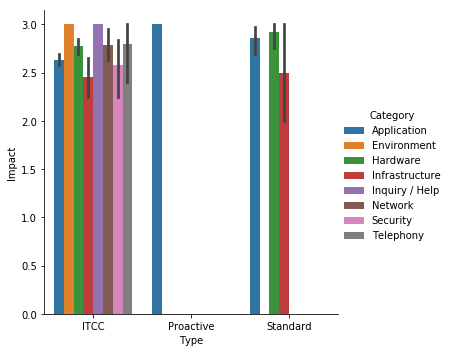

In [42]:
seaborn.catplot(x="Type", y="Impact", hue="Category", kind="bar", data=data);

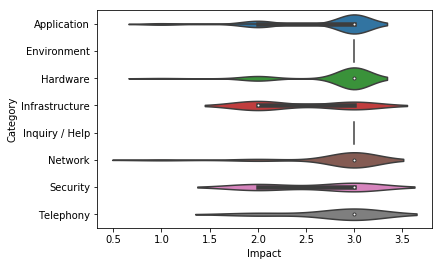

In [43]:
seaborn.violinplot(y='Category',x='Impact',data=data)

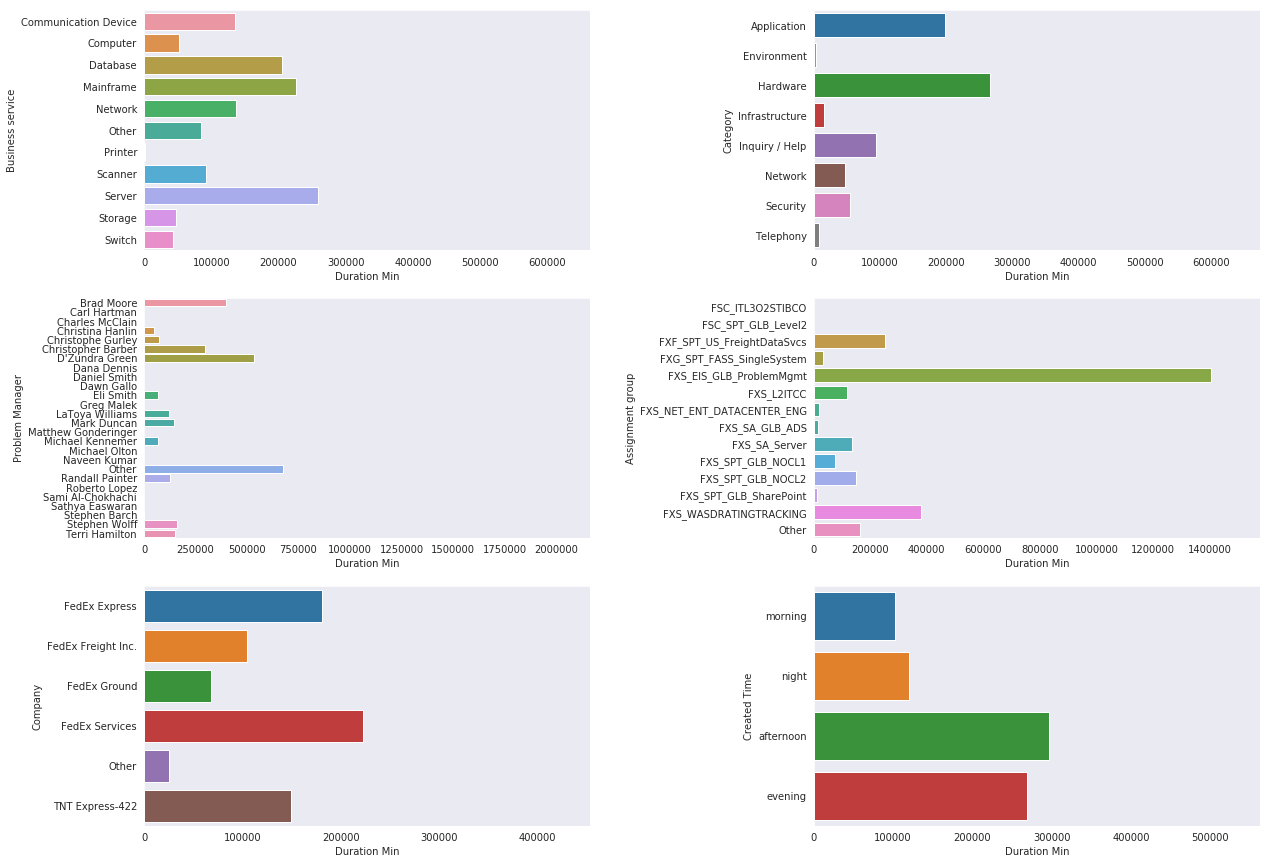

In [79]:
fig, ax = plt.subplots(3,2)
plt.subplots_adjust(wspace=.5, hspace=.2)
fig.set_figwidth(20)
fig.set_figheight(15)
seaborn.barplot('Duration Min', 'Business service', errwidth=0, data=data, ax=ax[0,0])
seaborn.barplot('Duration Min', 'Category', errwidth=0, data=data, ax=ax[0,1])
seaborn.barplot('Duration Min', 'Problem Manager', errwidth=0, data=data, ax=ax[1,0])
seaborn.barplot('Duration Min', 'Assignment group', errwidth=0, data=data, ax=ax[1,1])
seaborn.barplot('Duration Min', 'Company', errwidth=0, data=data, ax=ax[2,0])
seaborn.barplot('Duration Min', 'Created Time', errwidth=0, data=data, ax=ax[2,1])

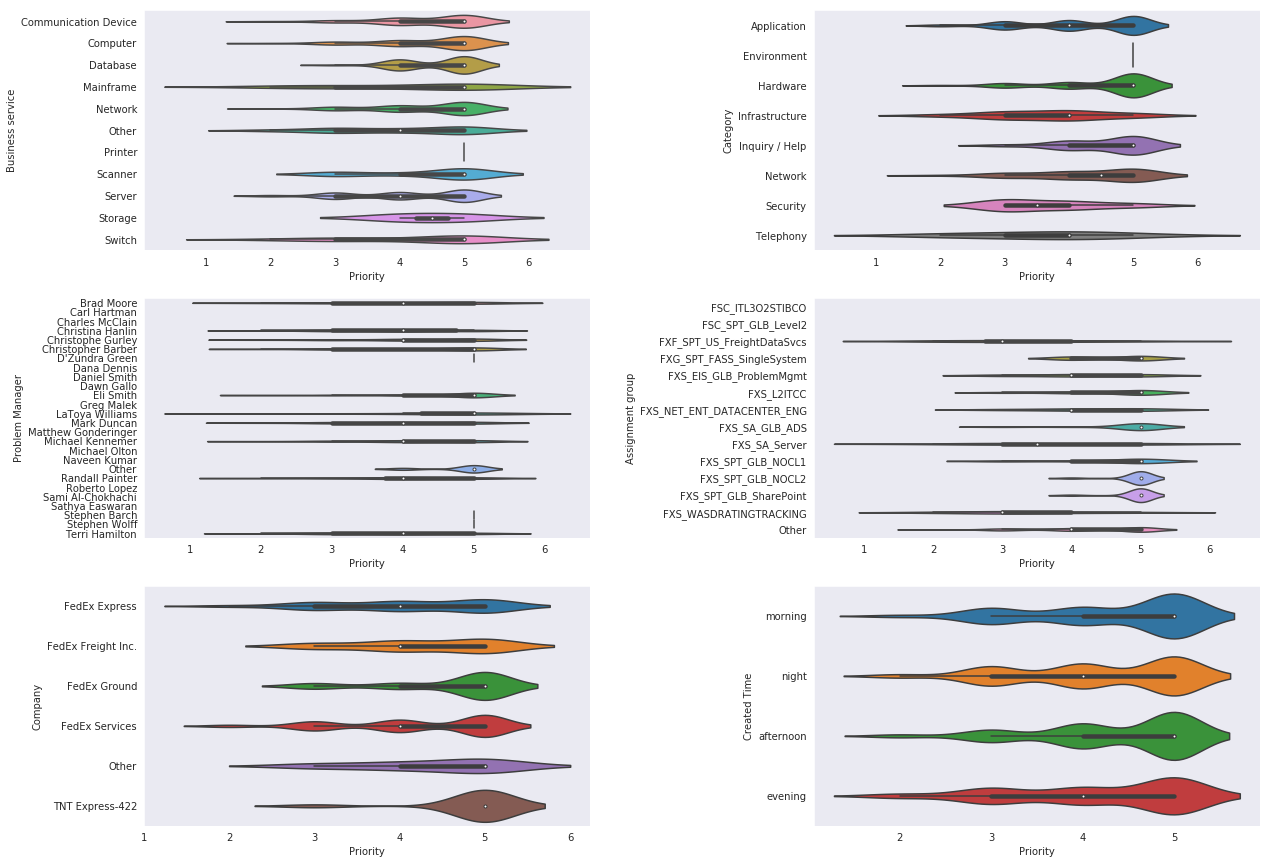

In [77]:
fig, ax = plt.subplots(3,2)
plt.subplots_adjust(wspace=.5, hspace=.2)
fig.set_figwidth(20)
fig.set_figheight(15)
seaborn.set_style("dark")
seaborn.violinplot('Priority', 'Business service', errwidth=0, data=data, ax=ax[0,0])
seaborn.violinplot('Priority', 'Category', errwidth=0, data=data, ax=ax[0,1])
seaborn.violinplot('Priority', 'Problem Manager', errwidth=0, data=data, ax=ax[1,0])
seaborn.violinplot('Priority', 'Assignment group', errwidth=0, data=data, ax=ax[1,1])
seaborn.violinplot('Priority', 'Company', errwidth=0, data=data, ax=ax[2,0])
seaborn.violinplot('Priority', 'Created Time', errwidth=0, data=data, ax=ax[2,1])

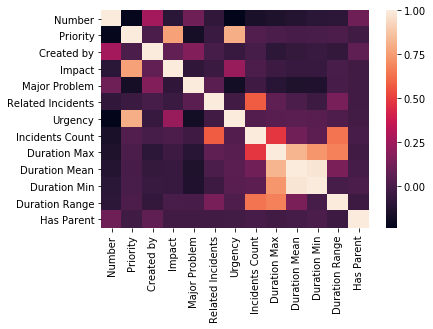

In [73]:
corr = data.corr()
seaborn.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## Set up for modeling

### Split up dependent and independent variables

In [ ]:
y = data['Category']
x = data.drop('Category', axis=1)

### Dummy variables for categories

In [ ]:
x = pd.get_dummies(x, columns=['Business service', 'Company', 'Problem Manager', 'Type'])
x.head()

## Model using K-means

In [ ]:
model = KMeans(n_clusters=8)
model.fit(x)

In [ ]:
smallX = x.drop('Created', axis=1)

In [ ]:
model = KMeans(n_clusters=8)
model.fit(smallX)

In [ ]:
data['kmeans'] = model.labels_

In [ ]:
metrics.adjusted_rand_score(data['Category'],data['kmeans'])

In [ ]:
pca = PCA()
pca.fit(smallX)

In [ ]:
pca.explained_variance_ratio_

In [ ]:
pca = PCA(n_components=2)
pca.fit(smallX)

In [ ]:
pca.explained_variance_ratio_

In [ ]:
transformed = pca.transform(smallX)

In [ ]:
km = KMeans(n_clusters=8)
km.fit(transformed)
data['pca'] = km.labels_

In [ ]:
metrics.adjusted_rand_score(data['Category'],data['kmeans'])

### Classify using Decision Tree

In [83]:
data = data.drop(['Created', 'Duration Max', 'Duration Min', 'Duration Range',
                  'Short description', 'Keywords'], axis=1)
data.dtypes

Number                  int64
Priority                int64
Business service     category
Category             category
Company              category
Created Time         category
Created by              int64
Impact                  int64
Major Problem            bool
Problem Manager      category
Related Incidents       int64
Type                 category
Urgency                 int64
Incidents Count         int64
Assignment group     category
Duration Mean         float64
Has Parent               bool
dtype: object

In [90]:
data = data.set_index('Number')

In [96]:
X = data.drop('Category', axis=1).values
X

array([[5, 'Server', 'FedEx Services', ..., 'Other', 3346.0, True],
       [5, 'Computer', 'FedEx Services', ..., 'Other', 7250.0, True],
       [5, 'Switch', 'FedEx Services', ..., 'FXS_SPT_GLB_NOCL1', 6856.0,
        True],
       ...,
       [5, 'Database', 'FedEx Services', ..., 'Other', 3885203.846153846,
        True],
       [5, 'Scanner', 'FedEx Services', ..., 'Other', 9075.0, True],
       [5, 'Communication Device', 'FedEx Express', ..., 'Other',
        2474298.0, True]], dtype=object)

In [99]:
le = preprocessing.LabelEncoder()
for col in range(len(X[0])):
    X[:,col] = le.fit_transform(X[:,col])

In [100]:
y = data['Category'].values
y

[Hardware, Hardware, Network, Hardware, Network, ..., Application, Application, Application, Hardware, Hardware]
Length: 688
Categories (8, object): [Application, Environment, Hardware, Infrastructure, Inquiry / Help, Network, Security, Telephony]

In [115]:
y = le.fit_transform(y)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
tree_gini = DecisionTreeClassifier(criterion='gini',random_state=100, max_depth=5, min_samples_leaf=5)
tree_gini.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [119]:
tree_entropy = DecisionTreeClassifier(criterion='entropy', random_state=100, max_depth=5, min_samples_leaf=5)
tree_entropy.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [122]:
y_pred = tree_gini.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 5, 5, 0, 5, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 5, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 5, 0, 0, 2, 0, 2, 0, 0])

In [123]:
y_pred_entropy = tree_entropy.predict(X_test)
y_pred_entropy

array([0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0,
       0, 5, 5, 0, 5, 0, 5, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 2, 2, 5, 0, 0, 0, 5, 0,
       0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       2, 5, 0, 0, 0, 0, 0, 0, 0])

In [124]:
accuracy_score(y_test, y_pred)

0.6859903381642513